In [1]:
import sys, time
sys.path.insert(0, "..")

import torch
import matplotlib.pyplot as plt
import numpy as np
from src.pinns import PINN
from src.utils.visualization import TrainingDataVisualizer as TDV

In [2]:
# reproducibility
torch.manual_seed(31)

In [3]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch.autograd as autograd
# Example 1: 2D p-poisson equation
def pde_residual(coords, u_pred):
    """
    Compute the residual of the 2D p-Laplacian Poisson equation

        −∇·( |∇u|^(p-2) ∇u ) = 1

    Args:
        coords (torch.Tensor): shape (N,2) input points (x,y), requires_grad=True
        u_pred (torch.Tensor): shape (N,1) model's predicted u at coords
        p (float): exponent in p-Laplacian

    Returns:
        torch.Tensor: PDE residual r(x,y) = −∇·( |∇u|^(p-2) ∇u ) - 1
    """
    p = 2.0  # p-Laplacian exponent
    # 1) Compute gradient ∇u = (∂u/∂x, ∂u/∂y)
    u_grad = autograd.grad(
        outputs=u_pred,
        inputs=coords,
        grad_outputs=torch.ones_like(u_pred).to(device),
        retain_graph=True,
        create_graph=True
    )[0]
    u_grad_x = u_grad[:, 0]
    u_grad_y = u_grad[:, 1]

    # 2) Compute |∇u|^(p−2)
    grad_norm_power = (u_grad_x**2 + u_grad_y**2)**((p - 2) / 2)

    # 3) Form flux q = |∇u|^(p−2) ∇u
    flux_x = grad_norm_power * u_grad_x
    flux_y = grad_norm_power * u_grad_y

    # 4) Compute divergence ∇·q = ∂q_x/∂x + ∂q_y/∂y
    div_q_x = autograd.grad(
        outputs=flux_x,
        inputs=coords,
        grad_outputs=torch.ones_like(flux_x).to(device),
        retain_graph=True,
        create_graph=True
    )[0][:, 0]
    div_q_y = autograd.grad(
        outputs=flux_y,
        inputs=coords,
        grad_outputs=torch.ones_like(flux_y).to(device),
        retain_graph=True,
        create_graph=True
    )[0][:, 1]

    p_laplacian = div_q_x + div_q_y

    # 5) PDE residual: −∇·( |∇u|^(p−2) ∇u ) − 1
    return -p_laplacian - 1


In [5]:
# 2) instantiate PINN
model = PINN(
    pde_residual=pde_residual,
    input_dim=2,
    hidden_dim=50,
    output_dim=1,
    num_hidden_layers=4,
    Nd=50, # number of boundary points
    Nc=1000, # number of collocation points
    device=device
)
model.to(device)
print("Using device:", next(model.parameters()).device)


Using device: cpu


In [6]:
# grab the data generated in PINN.__init__
x_train_Nu = model.x_train_Nu
u_train_Nu = model.u_train_Nu
x_train_Nf = model.x_train_Nf

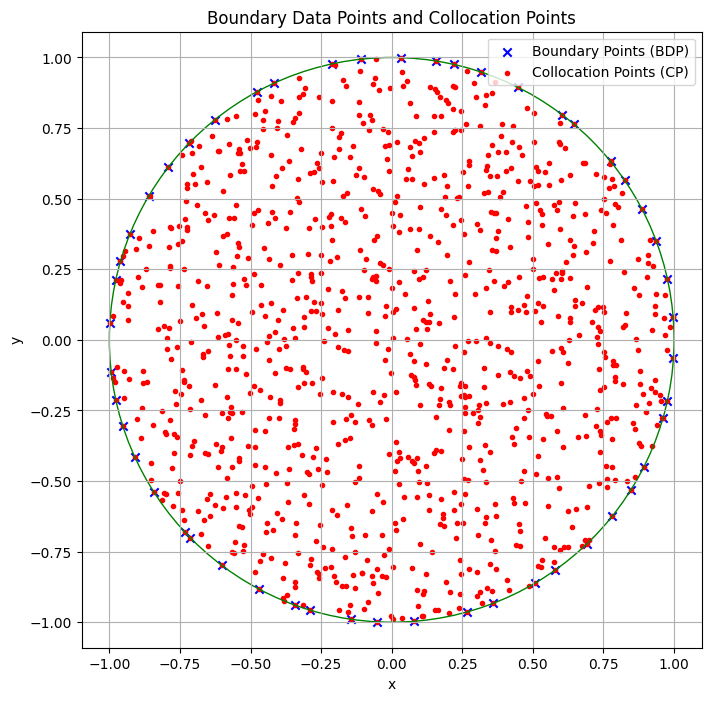

In [7]:
TDV.visualize_training_data(x_train_Nu, x_train_Nf)

In [8]:
pi = torch.tensor(np.pi, dtype=torch.float).to(device)

In [9]:
epochs = 0
loss_values1 = 1
loss_values2 = 1
error = 1
loss_values = []

In [10]:
start_time = time.time()
while loss_values2 > 1e-4:
    loss = model(bc_weight=10)
    loss_values.append(loss.item())

    if epochs == 0:
        print("Training Loss ----- Test Loss")
        loss_values1 = 1
        loss_values2 = loss_values[0]
        error = ((loss_values2 - loss_values1)**2)
    else:
        loss_values1 = loss_values[epochs-1]
        loss_values2 = loss_values[epochs]
        error = ((loss_values2 - loss_values1)**2)

    if epochs % 500 == 0:
        print(epochs,'-',loss)

    epochs += 1

RuntimeError: One of the differentiated Tensors does not require grad

In [ ]:
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

In [ ]:
loss_values